In [1]:
from config_path import add_to_sys_path
add_to_sys_path()  # Call the function to add path

import numpy as np
from sympy.physics.wigner import wigner_3j,wigner_6j
import sympy as sy
from numpy import linalg as LA
from IPython.display import Latex,display
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
sns.set_palette('terrain')
from molecular_structure import MoleculeLevels
np.set_printoptions(precision=5, suppress=True)

In [2]:
# X010 = MoleculeLevels.initialize_state('CaOH','40','X010',N_list,M_values = 'custom',I=[0,1/2],S=1/2,round=16,M_range=[1])
X010 = MoleculeLevels.initialize_state('CaOH','40','X010',[1,2],M_values = 'all',I=[0,0],S=1/2,round=8)

Text(0.5, 1.0, '$^{40}$CaOH $\\tilde{X}(010)$, N=1, Free Field')

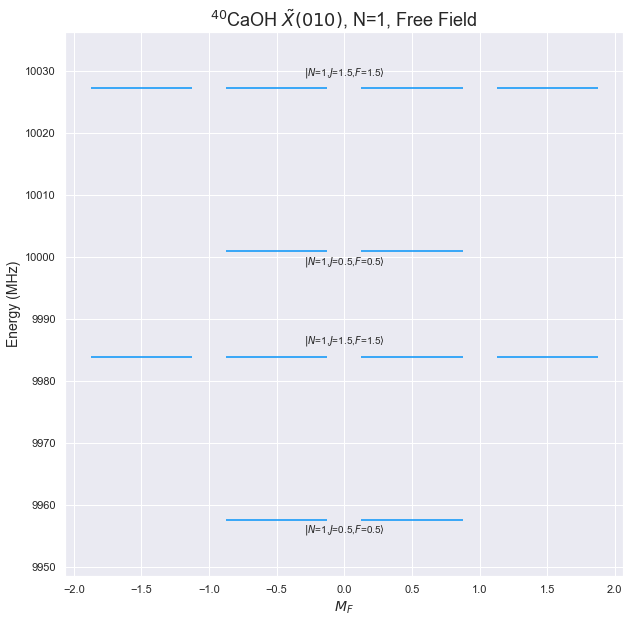

In [3]:
X010.display_levels(0,1e-8,'F',idx=X010.select_q({'N':1}),label_q=[q for q in X010.q_str if q!='K'],alt_label=True)
plt.title(X010.state_str+', N=1, Free Field',fontsize=18)

In [4]:
Efield = 0
Bfield = 1e-6
evals, evecs = X010.eigensystem(Efield,Bfield,order=True,method='torch')
M0_idx = X010.select_q({'N':1,'M':1/2})
print(M0_idx)
print('\n')
for i in M0_idx:
    display(Latex('$E = '+str(np.round(X010.evals0[i],4))+r'\:\mathrm{MHz}$'))
    print('Decoupled:')
    display(Latex(X010.gen_state_str(i,basis='decoupled',thresh=0.05,label_q=['K','M_N','M_S','M_I','M_F'],round=4)))
    print('Case A:')
    display(Latex(X010.gen_state_str(i,basis='aBJ',thresh=0.05,label_q=['K','J','F','Sigma','P','M'],round=4)))
    print('Case B:')
    display(Latex(X010.gen_state_str(i,thresh=0.05,round=4)))
    print('\n')

[ 0  4  6 10]




<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

In [5]:
X010.H_symbolic

Matrix([
[0.4670780207227*B_z - 0.24583286*E_z + 9979.2263,                                          10.8245,                                                 0,                                                 0,                                                   0,                                                   0,       -1.32109614318485*B_z + 0.173830082344483*E_z,                                                   0,                                                  0,                                                  0,                                                  0,                                                  0,                                                    0,                                                    0,                               -0.301082534504527*E_z,                                                    0,                                                     0,                                                     0,                                           

In [ ]:
import matrix_elements_sym as me
from functools import partial
from matrix_elements_sym import decouple_b_even

def H_even_X(q_numbers,params,matrix_elements,symbolic=True,E=0,B=0,M_values='all',precision=5):
    q_str = list(q_numbers)     # Get keys for quantum number dict
    if symbolic:
        Ez,Bz = sy.symbols('E_z B_z')
        size = len(q_numbers[q_str[0]])
        # Need to construct empty matrices to fill with matrix elements
        # Sympy does not like numpy arrays, so convert to list
        H0 = np.zeros((size,size)).tolist()
        V_B = np.zeros((size,size)).tolist()
        V_E = np.zeros((size,size)).tolist()
        #Iz = np.zeros((size,size)).tolist()
        #Sz = np.zeros((size,size)).tolist()
        for i in range(size):
            for j in range(size):
                # State out is LHS of bra ket, state in is RHS
                state_out = {q+'0':q_numbers[q][i] for q in q_str}
                state_in = {q+'1':q_numbers[q][j] for q in q_str}
                q_args = {**state_out,**state_in}
                elements = {term: sy.nsimplify(element(**q_args)) for term, element in matrix_elements.items()}
                # The Hamiltonian
                H0[i][j] = params['Be']*elements['N^2'] + params['Gamma_SR']*elements['N.S'] + \
                    params['bF']*elements['I.S'] + params['c']/3*sy.sqrt(6)*elements['T2_0(I,S)']
                if params.get('q_lD') is not None:
                    H0[i][j] += params['q_lD']/2*elements['l-doubling'] - params['Gamma_SR']*elements['NzSz']+params['Gamma_Prime']*elements['NzSz']
                if M_values!='none':
                    V_B[i][j]+=params['g_S']*params['mu_B']*elements['ZeemanZ']
                    V_E[i][j]+=-params['muE']*elements['StarkZ']
                # H[i][j] = round(H[i][j],precision)
                #Iz[i][j] = params['c']*elements['Iz']
                #Sz[i][j] = elements['Sz']
        # Need to construct IzSz term and add to Hamiltonian
        #H=matadd(H,matmult(Iz,Sz))
        # Create symbolic object
        H_symbolic = sy.Matrix(H0)+Ez*sy.Matrix(V_E)+Bz*sy.Matrix(V_B)
#         H0_num = np.array(H0).astype(np.float64)
#         V_E_num = np.array(V_E).astype(np.float64)
#         V_B_num = np.array(V_B).astype(np.float64)
        # Use symbolic object to create function that given E and B values, returns a numpy array
#         H_func = lambda E,B: H0_num + V_E_num*E + V_B_num*B
        # H_func = sy.lambdify((Ez,Bz), H_symbolic, modules='numpy')
        return H_symbolic

def decouple_b(input_qnumbers,output_qnumbers,S=1/2,I=1/2):
    input_keys = list(input_qnumbers)
    output_keys = list(output_qnumbers)
    input_size = len(input_qnumbers[input_keys[0]])
    output_size = len(output_qnumbers[output_keys[0]])
    basis_matrix = np.zeros((output_size,input_size)).tolist()
    for i in range(output_size):
        for j in range(input_size):
            decoupled_qnumbers = {q:output_qnumbers[q][i] for q in output_keys}
            b_qnumbers = {q:input_qnumbers[q][j] for q in input_keys}
            basis_matrix[i][j] = sy.nsimplify(decouple_b_even(decoupled_qnumbers,b_qnumbers,S=S,I=I))
    return basis_matrix
   
    

bBJ_even_X_matrix_elements={
        # Fine Structure
        'N^2': me.Rot_bBJ,                 # N^2 Rotation
        'N.S': me.SR_bBJ,                  # N.S Spin Rotation
        'l-doubling': me.lD_bBJ,           # Effective l doubling
        'NzSz': me.NzSz_bBJ,               # NzSz for bending mode

        # Hydrogen Hyperfine
        'I.S': me.IS_bBJ,                  # I.S Fermi Contact Interaction
        'T2_0(I,S)': me.T2IS_bBJ,          # I S dipolar interaction
        'Iz': me.Iz_bBJ,                   # I.n projection of I on internuclear axis n
        'Sz': me.Sz_bBJ,                   # S.n projection of S on internuclear axis n
        }

ext_fields = {
# External Fields
'ZeemanZ': me.ZeemanZ_bBJ,         # Zeeman interaction with lab z magnetic field
'StarkZ': me.StarkZ_bBJ            # Stark interaction with lab z electric field
}
bBJ_even_X_matrix_elements.update(ext_fields)
for term,element in bBJ_even_X_matrix_elements.items():       #iterate through, substitute hydrogen proton value
            bBJ_even_X_matrix_elements[term] = partial(element,I=1/2)

        

B,gamma,gammap, bF,c,b,q_lD,muE,muB,g_S,g_L = sy.symbols('B_{rot} gamma gamma^\' b_F c b q_{lD} D mu_B g_S g_L')
params_40X010 = {
'Be': B,
'Gamma_SR': gamma,
'Gamma_Prime': gammap,
'bF': 0,
'c': 0,
'b': b,
'q_lD': q_lD,
'muE': muE,
'mu_B': muB, #MHz/Gauss
'g_S': g_S,
'g_L': g_L,
}

def build_operator(q_numbers,parameter,operator_element,M_values='all',precision=5):
    q_str = list(q_numbers)     # Get keys for quantum number dict
    size = len(q_numbers[q_str[0]])
    # Need to construct empty matrices to fill with matrix elements
    # Sympy does not like numpy arrays, so convert to list
    H0 = np.zeros((size,size)).tolist()
    #Iz = np.zeros((size,size)).tolist()
    #Sz = np.zeros((size,size)).tolist()
    for i in range(size):
        for j in range(size):
            # State out is LHS of bra ket, state in is RHS
            state_out = {q+'0':q_numbers[q][i] for q in q_str}
            state_in = {q+'1':q_numbers[q][j] for q in q_str}
            q_args = {**state_out,**state_in}
            operator = sy.nsimplify(operator_element(**q_args))
            H0[i][j]+= parameter*operator
    H_symbolic = sy.Matrix(H0)
    return H_symbolic

In [3]:
N_list = [1]
print(N_list)

[1]


In [4]:
# X010 = MoleculeLevels.initialize_state('CaOH','40','X010',N_list,M_values = 'custom',I=[0,1/2],S=1/2,round=16,M_range=[1])
X010 = MoleculeLevels.initialize_state('CaOH','40','X010',N_list,M_values = 'all',I=[0,1/2],S=1/2,round=8)

In [30]:
evals, evecs = X010.eigensystem(0,1e-8,order=True,method='torch')

Text(0.5, 1.0, '$^{40}$CaOH $\\tilde{X}(010)$, N=1, Free Field')

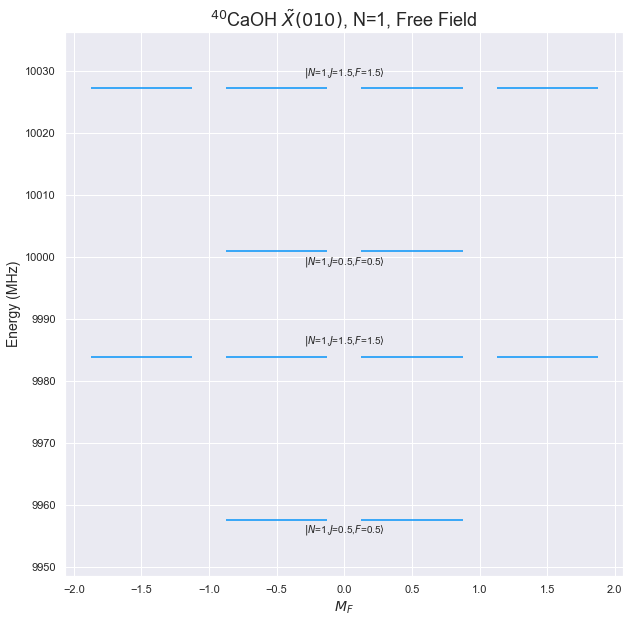

In [31]:
X010.display_levels(0,1e-8,'F',label_q=[q for q in X010.q_str if q!='K'],alt_label=True)
plt.title(X010.state_str+', N=1, Free Field',fontsize=18)

Text(0.5, 1.0, '$^{40}$CaOH $\\tilde{X}(010)$, N=1, 1000 V/cm, 10 G')

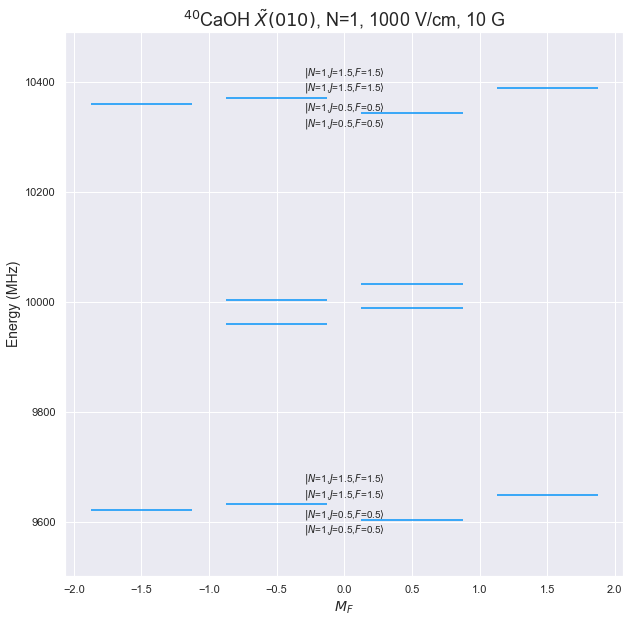

In [33]:
Efield = 1000
Bfield = 10
X010.display_levels(Efield,Bfield,'F',label_q=[q for q in X010.q_str if q!='K'],alt_label=True)
plt.title(X010.state_str+', N=1, {} V/cm, {} G'.format(Efield,Bfield),fontsize=18)

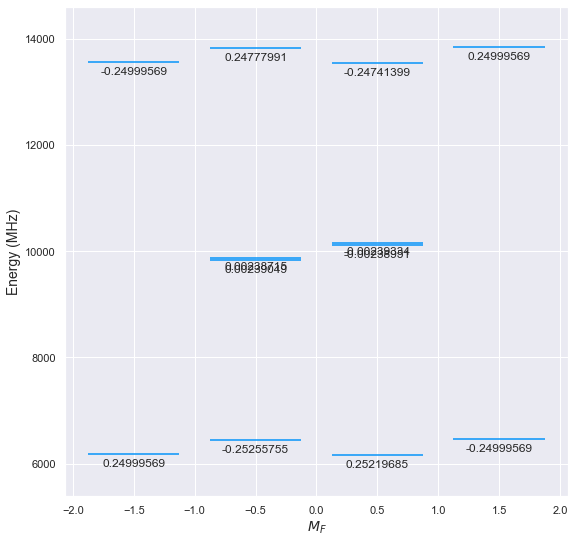

In [41]:
X010.display_PTV(,'EDM')

In [34]:
evals, evecs = X010.eigensystem(Efield,Bfield,order=True,method='torch')
M0_idx = X010.select_q({'M':[-3/2,-1/2,1/2,3/2]})
print(M0_idx)
print('\n')
for i in M0_idx:
    display(Latex('$E = '+str(np.round(X010.evals0[i],4))+r'\:\mathrm{MHz}$'))
    print('Decoupled:')
    display(Latex(X010.gen_state_str(i,basis='decoupled',thresh=0.05,label_q=['K','M_N','M_S','M_I','M_F'],round=4)))
    print('Case A:')
    display(Latex(X010.gen_state_str(i,basis='aBJ',thresh=0.05,label_q=['K','J','F','Sigma','P','M'],round=4)))
    print('Case B:')
    display(Latex(X010.gen_state_str(i,thresh=0.05,round=4)))
    print('\n')

[ 0  1  2  3  4  5  6  7  8  9 10 11]




<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

In [117]:
evals, evecs = X010.eigensystem(1000,1e-8,order=True,method='torch')
M0_idx = X010.select_q({'M':[0]})
print(M0_idx)
print('\n')
for i in M0_idx:
    display(Latex('$E = '+str(np.round(X010.evals0[i],4))+r'\:\mathrm{MHz}$'))
    print('Decoupled:')
    display(Latex(X010.gen_state_str(i,basis='decoupled',thresh=0.01,label_q=['K','M_N','M_S','M_I','M_F'],round=4)))
    print('Case A:')
    display(Latex(X010.gen_state_str(i,basis='aBJ',thresh=0.01,label_q=['J','K','Sigma','P','M'],round=4)))
    print('Case B:')
    display(Latex(X010.gen_state_str(i,thresh=0.01,round=4)))
    print('\n')

[ 2  3  8 11 12 15 18 19]




<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

In [42]:
Bz = np.linspace(1e-6,40,1000)
Ez = np.linspace(0,500,1000)

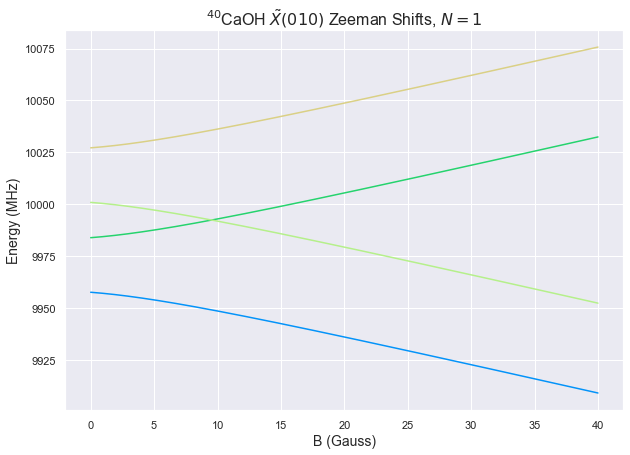

In [75]:
X010.ZeemanMap(Bz,0,plot=True)

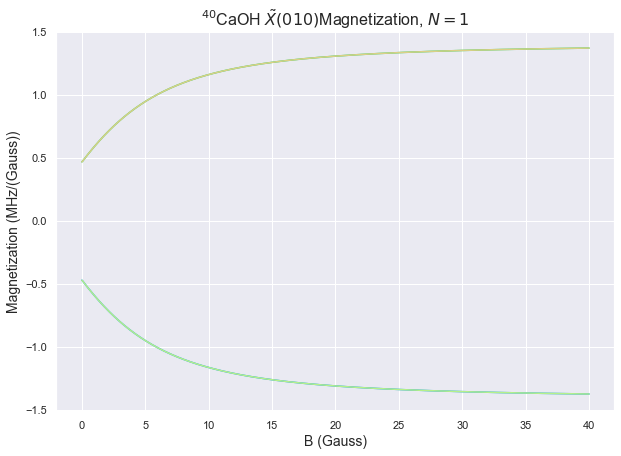

In [76]:
plt.figure(figsize=(10,7))
for (i,trace) in enumerate(X010.evals_B.T):
    grad = np.gradient(trace)/(Bz[1]-Bz[0])
    plt.plot(Bz,grad)
plt.xlabel('B (Gauss)',fontsize=14)
plt.ylabel('Magnetization (MHz/(Gauss))',fontsize=14)
plt.title(X010.state_str + r'Magnetization, $N={}$'.format(*X010.N_range),fontsize=16);

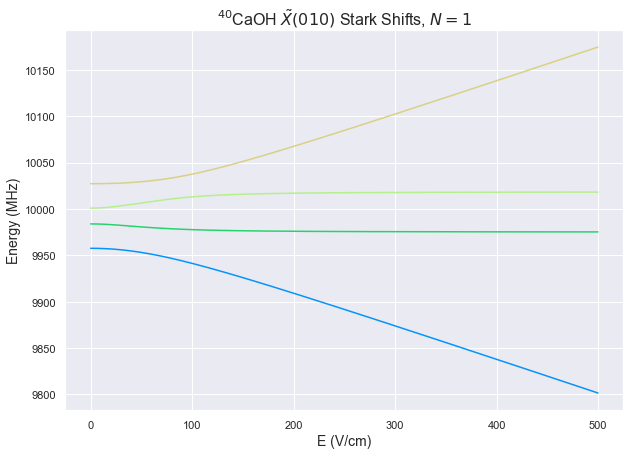

In [78]:
X010.StarkMap(Ez,1e-6,plot=True)
# X010.plot_evals_EB('E',kV_kG=True,GHz=True)

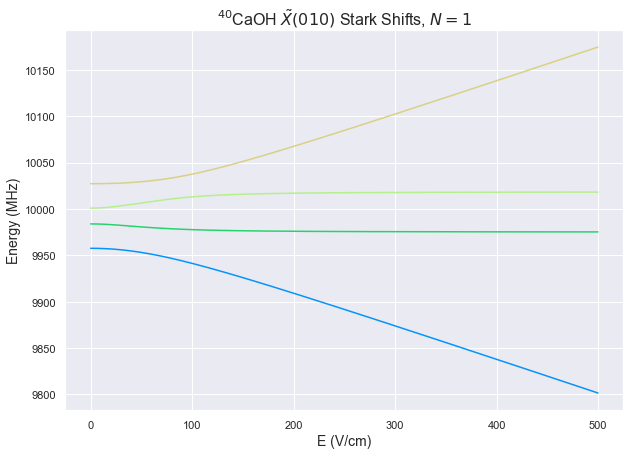

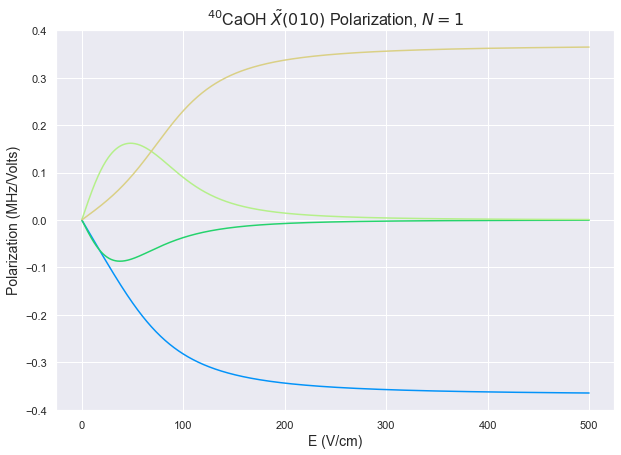

In [98]:
plt.figure(figsize=(10,7))
for (i,trace) in enumerate(X010.evals_E.T):
    plt.plot(Ez,trace)
plt.xlabel('E (V/cm)',fontsize=14)
plt.ylabel('Energy (MHz)',fontsize=14)
plt.title(r'$^{40}$CaOH $\tilde{X}(010)$ Stark Shifts, $N=1$',fontsize=16);

plt.figure(figsize=(10,7))
for (i,trace) in enumerate(X010.evals_E.T):
    grad = np.gradient(trace)/(Ez[1]-Ez[0])
    plt.plot(Ez,grad)
plt.xlabel('E (V/cm)',fontsize=14)
plt.ylabel('Polarization (MHz/Volts)',fontsize=14)
plt.title(r'$^{40}$CaOH $\tilde{X}(010)$ Polarization, $N=1$',fontsize=16);

We can display a plot of the energy levels at arbitray field. (The code does not handle parity labeling well, so I am leaving out L for zero field.)

Text(0.5, 1.0, '$^{40}$CaOH $\\tilde{X}(010)$, N=1, 0.5 kV/cm')

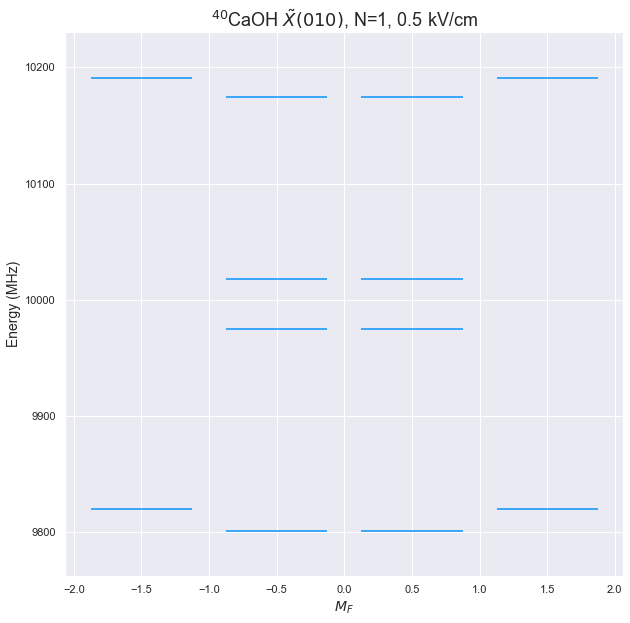

In [47]:
X010.display_levels(500,1e-7,'F',label=None,alt_label=True)
plt.title(X010.state_str+', N=1, 0.5 kV/cm',fontsize=18)

We can also look at PT violating shifts. Here, we consider the EDM shifts as a function of E field. 

In [48]:
X010.eigensystem(0,1e-8);

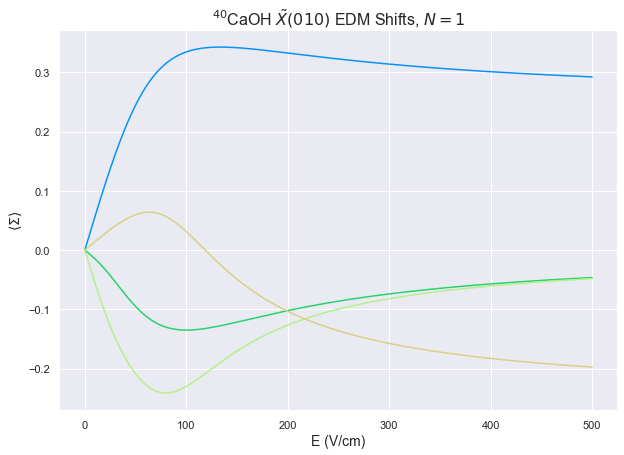

In [85]:
X010.PTV_Map('EDM',E_or_B='E',plot=True)

We can look specifically at the upper and lower Stark manifolds at a given field value too.

Text(0.5, 1.0, '$^{40}$CaOH $\\tilde{X}(010)$, EDM shifts at 60.8 V/cm')

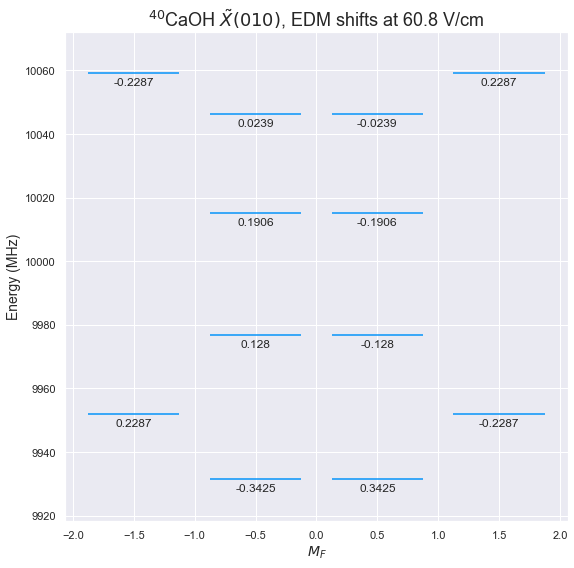

In [51]:
X010.display_PTV(133,1e-7,'EDM',round=4)
plt.title(X010.state_str+', EDM shifts at 60.8 V/cm',fontsize=18)

In [60]:
X010.eigensystem(1000,0)
M0_idx = X010.select_q({'M':[1]})
print(M0_idx)
print('\n')
for i in M0_idx:
    display(Latex('$E = '+str(np.round(X010.evals0[i],4))+r'\:\mathrm{MHz}$'))
    print('Decoupled:')
    display(Latex(X010.gen_state_str(i,basis='decoupled',thresh=0.01,label_q=['K','M_N','M_S','M_I','M_F'],round=4)))
    print('Case A:')
    display(Latex(X010.gen_state_str(i,basis='aBJ',thresh=0.01,label_q=['K','Sigma','P','M'],round=4)))
    print('Case B:')
    display(Latex(X010.gen_state_str(i,thresh=0.01,round=4)))
    print('\n')

[0 1 2 3 4 5]




<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

In [50]:
X010.eigensystem(100,1e-2)
(sy.Matrix(X010.evecs0[0]).T*X010.H_symbolic*sy.Matrix(X010.evecs0[0]))[0]

-0.048487643331535*Bz - 0.277154404334809*Ez + 9969.35364112334

In [43]:
(sy.Matrix(X010.evecs0[1]).T*X010.H_symbolic*sy.Matrix(X010.evecs0[1]))[0]

1.28069264538709*Bz - 0.368490639112473*Ez + 9987.63731699745

In [20]:
import matrix_elements_sym as me
from functools import partial
from matrix_elements_sym import decouple_b_even

def H_even_X(q_numbers,params,matrix_elements,symbolic=True,E=0,B=0,M_values='all',precision=5):
    q_str = list(q_numbers)     # Get keys for quantum number dict
    if symbolic:
        Ez,Bz = sy.symbols('E_z B_z')
        size = len(q_numbers[q_str[0]])
        # Need to construct empty matrices to fill with matrix elements
        # Sympy does not like numpy arrays, so convert to list
        H0 = np.zeros((size,size)).tolist()
        V_B = np.zeros((size,size)).tolist()
        V_E = np.zeros((size,size)).tolist()
        #Iz = np.zeros((size,size)).tolist()
        #Sz = np.zeros((size,size)).tolist()
        for i in range(size):
            for j in range(size):
                # State out is LHS of bra ket, state in is RHS
                state_out = {q+'0':q_numbers[q][i] for q in q_str}
                state_in = {q+'1':q_numbers[q][j] for q in q_str}
                q_args = {**state_out,**state_in}
                elements = {term: sy.nsimplify(element(**q_args)) for term, element in matrix_elements.items()}
                # The Hamiltonian
                H0[i][j] = params['Be']*elements['N^2'] + params['Gamma_SR']*elements['N.S'] + \
                    params['bF']*elements['I.S'] + params['c']/3*sy.sqrt(6)*elements['T2_0(I,S)']
                if params.get('q_lD') is not None:
                    H0[i][j] += params['q_lD']/2*elements['l-doubling'] - params['Gamma_SR']*elements['NzSz']+params['Gamma_Prime']*elements['NzSz']
                if M_values!='none':
                    V_B[i][j]+=params['g_S']*params['mu_B']*elements['ZeemanZ']
                    V_E[i][j]+=-params['muE']*elements['StarkZ']
                # H[i][j] = round(H[i][j],precision)
                #Iz[i][j] = params['c']*elements['Iz']
                #Sz[i][j] = elements['Sz']
        # Need to construct IzSz term and add to Hamiltonian
        #H=matadd(H,matmult(Iz,Sz))
        # Create symbolic object
        H_symbolic = sy.Matrix(H0)+Ez*sy.Matrix(V_E)+Bz*sy.Matrix(V_B)
#         H0_num = np.array(H0).astype(np.float64)
#         V_E_num = np.array(V_E).astype(np.float64)
#         V_B_num = np.array(V_B).astype(np.float64)
        # Use symbolic object to create function that given E and B values, returns a numpy array
#         H_func = lambda E,B: H0_num + V_E_num*E + V_B_num*B
        # H_func = sy.lambdify((Ez,Bz), H_symbolic, modules='numpy')
        return H_symbolic

def decouple_b(input_qnumbers,output_qnumbers,S=1/2,I=1/2):
    input_keys = list(input_qnumbers)
    output_keys = list(output_qnumbers)
    input_size = len(input_qnumbers[input_keys[0]])
    output_size = len(output_qnumbers[output_keys[0]])
    basis_matrix = np.zeros((output_size,input_size)).tolist()
    for i in range(output_size):
        for j in range(input_size):
            decoupled_qnumbers = {q:output_qnumbers[q][i] for q in output_keys}
            b_qnumbers = {q:input_qnumbers[q][j] for q in input_keys}
            basis_matrix[i][j] = sy.nsimplify(decouple_b_even(decoupled_qnumbers,b_qnumbers,S=S,I=I))
    return basis_matrix
   
    

bBJ_even_X_matrix_elements={
        # Fine Structure
        'N^2': me.Rot_bBJ,                 # N^2 Rotation
        'N.S': me.SR_bBJ,                  # N.S Spin Rotation
        'l-doubling': me.lD_bBJ,           # Effective l doubling
        'NzSz': me.NzSz_bBJ,               # NzSz for bending mode

        # Hydrogen Hyperfine
        'I.S': me.IS_bBJ,                  # I.S Fermi Contact Interaction
        'T2_0(I,S)': me.T2IS_bBJ,          # I S dipolar interaction
        'Iz': me.Iz_bBJ,                   # I.n projection of I on internuclear axis n
        'Sz': me.Sz_bBJ,                   # S.n projection of S on internuclear axis n
        }

ext_fields = {
# External Fields
'ZeemanZ': me.ZeemanZ_bBJ,         # Zeeman interaction with lab z magnetic field
'StarkZ': me.StarkZ_bBJ            # Stark interaction with lab z electric field
}
bBJ_even_X_matrix_elements.update(ext_fields)
for term,element in bBJ_even_X_matrix_elements.items():       #iterate through, substitute hydrogen proton value
            bBJ_even_X_matrix_elements[term] = partial(element,I=1/2)

        

B,gamma,gammap, bF,c,b,q_lD,muE,muB,g_S,g_L = sy.symbols('B_{rot} gamma gamma^\' b_F c b q_{lD} D mu_B g_S g_L')
params_40X010 = {
'Be': B,
'Gamma_SR': gamma,
'Gamma_Prime': gammap,
'bF': 0,
'c': 0,
'b': b,
'q_lD': q_lD,
'muE': muE,
'mu_B': muB, #MHz/Gauss
'g_S': g_S,
'g_L': g_L,
}

def build_operator(q_numbers,parameter,operator_element,M_values='all',precision=5):
    q_str = list(q_numbers)     # Get keys for quantum number dict
    size = len(q_numbers[q_str[0]])
    # Need to construct empty matrices to fill with matrix elements
    # Sympy does not like numpy arrays, so convert to list
    H0 = np.zeros((size,size)).tolist()
    #Iz = np.zeros((size,size)).tolist()
    #Sz = np.zeros((size,size)).tolist()
    for i in range(size):
        for j in range(size):
            # State out is LHS of bra ket, state in is RHS
            state_out = {q+'0':q_numbers[q][i] for q in q_str}
            state_in = {q+'1':q_numbers[q][j] for q in q_str}
            q_args = {**state_out,**state_in}
            operator = sy.nsimplify(operator_element(**q_args))
            H0[i][j]+= parameter*operator
    H_symbolic = sy.Matrix(H0)
    return H_symbolic

In [21]:
H_sym = H_even_X(X010.q_numbers,params_40X010,bBJ_even_X_matrix_elements,symbolic=True,E=0,B=0,M_values='all',precision=8)

In [22]:
(H_sym)

Matrix([
[            B_{rot} - gamma/2 - gamma^'/2,                                   -q_{lD},                                                        0,                                                        0,                 -B_z*g_S*mu_B/6 + D*E_z/3,                                         0,                                                         0,                                                         0,                                                               0,                                                               0, -sqrt(2)*B_z*g_S*mu_B/3 + sqrt(2)*D*E_z/6,                                         0,                                                              0,                                                              0,                                                         0,                                                         0,                                                         0,                                                         0,     

In [23]:
NzSz = build_operator(X010.q_numbers,params_40X010['Gamma_Prime'],bBJ_even_X_matrix_elements['NzSz'],precision=8)
NS = build_operator(X010.q_numbers,params_40X010['Gamma_SR'],bBJ_even_X_matrix_elements['N.S'],precision=8)

In [24]:
NS-NzSz

Matrix([
[-gamma + gamma^'/2,                  0,                  0,                  0,                  0,                  0,                  0,                  0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0],
[                 0, -gamma + gamma^'/2,                  0,                  0,                  0,                  0,                  0,                  0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                  

In [25]:
inputt = X010.q_numbers
output = X010.alt_q_numbers['decoupled']
basis_matrix = sy.Matrix(decouple_b(inputt,output,I=1/2))

In [26]:
H_dcpl = basis_matrix*H_sym*basis_matrix.T

In [27]:
NzSz_dcpl = basis_matrix*NzSz*basis_matrix.T
NS_dcpl = basis_matrix*NS*basis_matrix.T

In [28]:
SR_dcpl = NS_dcpl-NzSz_dcpl

In [29]:
SR_dcpl

Matrix([
[gamma/2 - gamma^'/4,                   0,                   0,                   0,                                   0,                                   0,                                   0,                                   0,                                   0,                                   0,                                   0,                                   0,                                   0,                                   0,                                   0,                                   0,                                   0,                                   0,                                   0,                                   0,                   0,                   0,                   0,                   0],
[                  0, gamma/2 - gamma^'/4,                   0,                   0,                                   0,                                   0,                                   0,                                  

In [24]:
ilist = range(0,24)
for i in ilist:
    print(i)
    for k,v in X010.alt_q_numbers['decoupled'].items():
        print('{} = {}'.format(k,v[i]))

0
K = -1
N = 1
M_N = -1
M_S = -0.5
M_I = 0
M_F = -1.5
1
K = 1
N = 1
M_N = -1
M_S = -0.5
M_I = 0
M_F = -1.5
2
K = -1
N = 1
M_N = -1
M_S = 0.5
M_I = 0
M_F = -0.5
3
K = 1
N = 1
M_N = -1
M_S = 0.5
M_I = 0
M_F = -0.5
4
K = -1
N = 1
M_N = 0
M_S = -0.5
M_I = 0
M_F = -0.5
5
K = 1
N = 1
M_N = 0
M_S = -0.5
M_I = 0
M_F = -0.5
6
K = -1
N = 1
M_N = 0
M_S = 0.5
M_I = 0
M_F = 0.5
7
K = 1
N = 1
M_N = 0
M_S = 0.5
M_I = 0
M_F = 0.5
8
K = -1
N = 1
M_N = 1
M_S = -0.5
M_I = 0
M_F = 0.5
9
K = 1
N = 1
M_N = 1
M_S = -0.5
M_I = 0
M_F = 0.5
10
K = -1
N = 1
M_N = 1
M_S = 0.5
M_I = 0
M_F = 1.5
11
K = 1
N = 1
M_N = 1
M_S = 0.5
M_I = 0
M_F = 1.5
12


IndexError: list index out of range

In [25]:
vec = np.zeros(24)
vec[6] = 1/sy.sqrt(2) #
vec[17] = 1/sy.sqrt(2)

In [26]:
NS_dcpl-NzSz_dcpl

Matrix([
[gamma/4,       0,               0,               0,               0,               0,               0,               0,               0,               0,       0,       0],
[      0, gamma/4,               0,               0,               0,               0,               0,               0,               0,               0,       0,       0],
[      0,       0,        -gamma/4,               0, sqrt(2)*gamma/4,               0,               0,               0,               0,               0,       0,       0],
[      0,       0,               0,        -gamma/4,               0, sqrt(2)*gamma/4,               0,               0,               0,               0,       0,       0],
[      0,       0, sqrt(2)*gamma/4,               0,               0,               0,               0,               0,               0,               0,       0,       0],
[      0,       0,               0, sqrt(2)*gamma/4,               0,               0,               0,               0, 

In [27]:
H_dcpl=sy.simplify(H_dcpl)
H_dcpl

Matrix([
[-B_z*g_S*mu_B/2 + B_{rot} - D*E_z/2 + gamma/4,                                       -q_{lD},                                            0,                                            0,                         0,                         0,                        0,                        0,                                             0,                                             0,                                            0,                                            0],
[                                      -q_{lD}, -B_z*g_S*mu_B/2 + B_{rot} + D*E_z/2 + gamma/4,                                            0,                                            0,                         0,                         0,                        0,                        0,                                             0,                                             0,                                            0,                                            0],
[                              

In [135]:
X010.eigensystem(1000,0)
even = sy.Matrix([0,1/sy.sqrt(2),0,0,0,0,1/sy.sqrt(2),0])
odd = sy.Matrix([1/sy.sqrt(2),0,0,0,0,0,0,-1/sy.sqrt(2)])
x = sy.simplify(even.T*H_dcpl*even)
y = sy.simplify(odd.T*H_dcpl*odd)
x[0]

B_{rot} + D*E_z/2 + b_F/4 + c/60 - gamma/4

In [136]:
y[0]

B_{rot} - D*E_z/2 + b_F/4 + c/60 - gamma/4

In [142]:
X010.eigensystem(1000,)
x = sy.Matrix(X010.evecs0[0]).T*H_sym*sy.Matrix(X010.evecs0[0])
y = sy.Matrix(X010.evecs0[1]).T*H_sym*sy.Matrix(X010.evecs0[1])
sy.N(x-y)[0]

-1.09823410572936e-11*B_z*g_S*mu_B + 3.74903172901661e-5*D*E_z - 0.00019018948895402*b_F - 0.0122648086400407*c - 5.8647193332706e-5*gamma + 0.00118230125639449*q_{lD}

In [42]:
X010.H_symbolic

Matrix([
[                           9980.21896666667,                                      21.649,         -0.4670780207227*Bz + 0.24583286*Ez,                                           0, -1.32109614318485*Bz + 0.173830082344483*Ez,                                           0,                                           0,                                           0],
[                                     21.649,                            9980.21896666667,                                           0,         -0.4670780207227*Bz - 0.24583286*Ez,                                           0, -1.32109614318485*Bz - 0.173830082344483*Ez,                                           0,                                           0],
[        -0.4670780207227*Bz + 0.24583286*Ez,                                           0,                            9978.89541111111,                                      21.649,                            1.14594510633293,                                          

In [17]:
X010.eigensystem(100000,0)
M0_idx = X010.select_q({'M':[0]})
print(M0_idx)
for i in M0_idx:
    print('E =',X010.evals0[i])
    display(Latex(X010.gen_state_str(i,basis='decoupled',thresh=0.001,label_q=['K','M_N','M_S','M_I','M_F'])))
#     display(Latex(X010.gen_state_str(i,basis='aBJ',thresh=0.05,label_q=['K','Sigma','P','M'])))
#     display(Latex(X010.gen_state_str(i,thresh=0.05)))

[0 1 2 3 4 5 6 7]
E = -26869.87053477218


<IPython.core.display.Latex object>

E = -26869.753213628093


<IPython.core.display.Latex object>

E = 9973.151313958582


<IPython.core.display.Latex object>

E = 10016.449292801037


<IPython.core.display.Latex object>

E = 10042.423225935365


<IPython.core.display.Latex object>

E = 10085.720997939427


<IPython.core.display.Latex object>

E = 46880.36769489169


<IPython.core.display.Latex object>

E = 46880.485222874166


<IPython.core.display.Latex object>

In [83]:
X010.eigensystem(0,1e-6)
X010.g_eff_Map(step=1e-6);

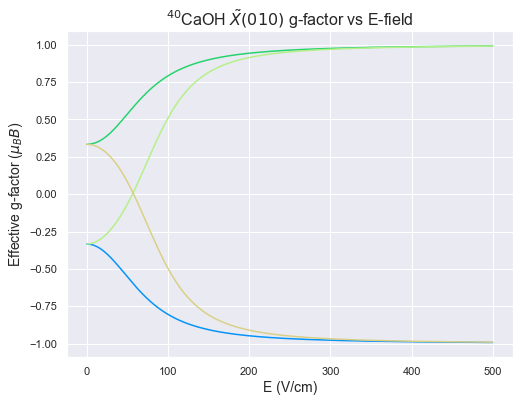

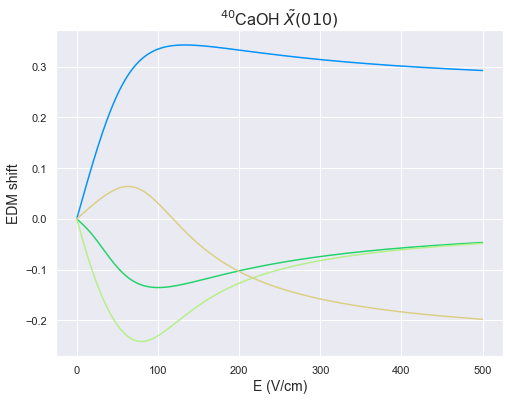

In [86]:
j = range(len(X010.evals0))
plt.figure(figsize=(8,6))
for i in range(len(X010.g_eff_E.T)):#range(len(X010_174.g_eff_E.T)):
    plt.plot(Ez,X010.g_eff_E.T[i])
plt.xlabel('E (V/cm)',fontsize=14)
plt.ylabel(r'Effective g-factor ($\mu_B B$)',fontsize=14)
plt.title(X010.state_str + ' g-factor vs E-field',fontsize=16);
plt.figure(figsize=(8,6))
for i in range(len(X010.g_eff_E.T)):#range(len(X010_174.PTV_E.T)):
    plt.plot(Ez,X010.PTV_E.T[i])
plt.xlabel('E (V/cm)',fontsize=14)
plt.ylabel('EDM shift',fontsize=14)
plt.title(X010.state_str,fontsize=16);

In [81]:
X010.eigensystem(0,1e-6)
M_idx = X010.select_q({'M':[1/2]})
print(M_idx)

[0 1 2 3]


IndexError: index 4 is out of bounds for axis 0 with size 4

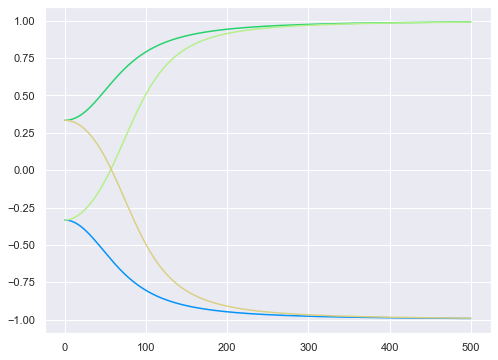

In [87]:
j = range(len(X010.evals0))
plt.figure(figsize=(8,6))
for i in range(10):#range(len(X010_174.g_eff_E.T)):
    plt.plot(Ez,X010.g_eff_E.T[i])
plt.xlabel('E (V/cm)',fontsize=14)
plt.ylabel(r'Effective g-factor ($\mu_B B$)',fontsize=14)
plt.title(X010.state_str + ' g-factor vs E-field',fontsize=16);
plt.xlim(53,73)
plt.figure(figsize=(8,6))
for i in range(12):#range(len(X010_174.PTV_E.T)):
    plt.plot(Ez,X010.PTV_E.T[i])
plt.xlabel('E (V/cm)',fontsize=14)
plt.ylabel('EDM shift',fontsize=14)
plt.title(X010.state_str,fontsize=16);
plt.xlim(53,73);

In [175]:
for j in [12,18]:
    g_eff = X010.g_eff_E.T[j]
    for i in range(1,len(g_eff)):
        if (g_eff[i]>0 and g_eff[i-1]<0) or g_eff[i]<0 and g_eff[i-1]>0:
            print('idx =',j)
            print('E field =',(Ez[i]+Ez[i-1])/2)
            print('PTV =,',(X010.PTV_E.T[j][i]+X010.PTV_E.T[j][i-1])/2)
            print('Energy =',(X010.evals_E.T[j][i]+X010.evals_E.T[j][i-1])/2)

idx = 12
E field = 60.83108310831083
PTV =, -0.22727988
Energy = 10008.053070099853
idx = 18
E field = 65.28152815281528
PTV =, 0.070567485
Energy = 10030.921999206803


In [196]:
X010.eigensystem(1000,1e-7)
M_idx = X010.select_q({'M':[0]})
idx = M_idx
for i in idx:
    print(idx)
    print(X010.g_eff_EB()[i])
    display(Latex('$E = '+str(np.round(X010.evals0[i],4))+r'\:\mathrm{MHz}$'))
    print('Decoupled:')
    display(Latex(X010.gen_state_str(i,basis='decoupled',thresh=0.05,label_q=['K','M_N','M_S','M_I','M_F'],round=4)))
    print('Case A:')
    display(Latex(X010.gen_state_str(i,basis='aBJ',thresh=0.05,label_q=['J','K','Sigma','P','M'],round=4)))
    print('Case B:')
    display(Latex(X010.gen_state_str(i,thresh=0.05,round=4)))
    print('\n')

[ 2  3  8 11 12 15 18 19]
3.8988801882439546e-05


<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>



[ 2  3  8 11 12 15 18 19]
7.797760376487909e-05


<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>



[ 2  3  8 11 12 15 18 19]
-1.2996267294146515e-05


<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>



[ 2  3  8 11 12 15 18 19]
-2.599253458829303e-05


<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>



[ 2  3  8 11 12 15 18 19]
-1.2996267294146515e-05


<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>



[ 2  3  8 11 12 15 18 19]
-3.8988801882439546e-05


<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>



[ 2  3  8 11 12 15 18 19]
-2.599253458829303e-05


<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>



[ 2  3  8 11 12 15 18 19]
1.2996267294146515e-05


<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

Text(0.5, 1.0, '$^{40}$CaOH $\\tilde{X}(010)$, EDM shifts at 65.28 V/cm')

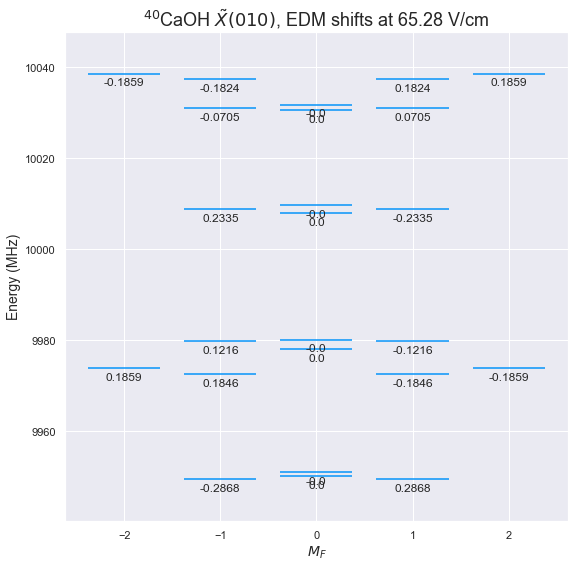

In [179]:
X010.display_PTV(65.28,1e-7,'EDM',round=4)
plt.title(X010.state_str+', EDM shifts at 65.28 V/cm',fontsize=18)

[ 1  3  5  9 13 15 17 21]
1 1.45e-05 499.7999799979998
3 1.45e-05 499.74997499749975
5 1.3e-07 105.06050605060506
9 1.3e-07 90.65906590659066
13 1.6e-07 105.71057105710571
15 1.8e-07 106.66066606660665
17 1.149e-05 499.8999899989999
21 1.149e-05 499.84998499849985


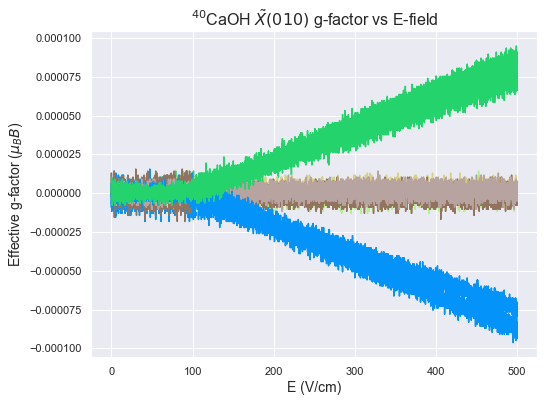

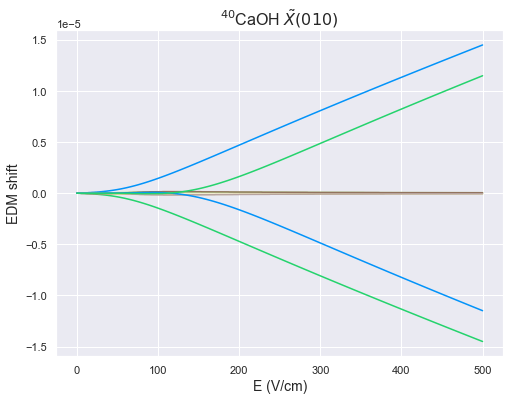

In [192]:
X010.eigensystem(0,1e-6)
M_idx = X010.select_q({'M':[0]})
print(M_idx)

j = range(len(X010.evals0))
plt.figure(figsize=(8,6))
for i in M_idx:#range(len(X010_174.g_eff_E.T)):
    plt.plot(Ez,X010.g_eff_E.T[i])
plt.xlabel('E (V/cm)',fontsize=14)
plt.ylabel(r'Effective g-factor ($\mu_B B$)',fontsize=14)
plt.title(X010.state_str + ' g-factor vs E-field',fontsize=16);
plt.figure(figsize=(8,6))
for i in M_idx:#range(len(X010_174.PTV_E.T)):
    plt.plot(Ez,X010.PTV_E.T[i])
    print(i,max(abs(X010.PTV_E.T[i])),Ez[np.argmax(abs(X010.PTV_E.T[i]))])
plt.xlabel('E (V/cm)',fontsize=14)
plt.ylabel('EDM shift',fontsize=14)
plt.title(X010.state_str,fontsize=16);

Text(0.5, 1.0, '$^{40}$CaOH $\\tilde{X}(010)$, EDM shifts at 1000 V/cm and 10 mG')

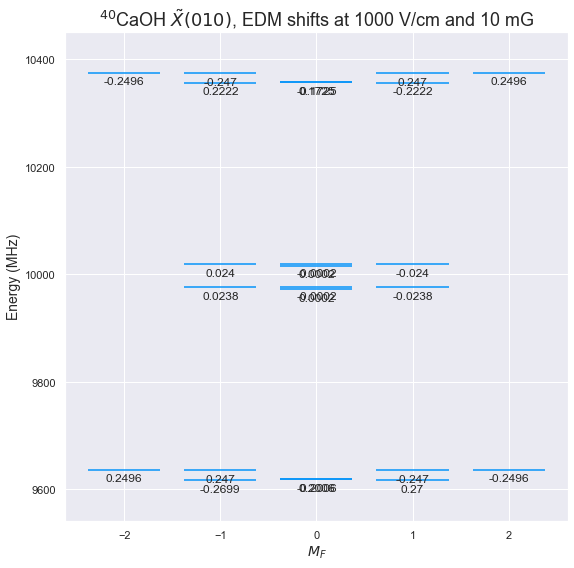

In [199]:
X010.display_PTV(1000,1e-2,'EDM',round=4)
plt.title(X010.state_str+', EDM shifts at 1000 V/cm and 10 mG',fontsize=18)

In [105]:
import time
X010_p = MoleculeLevels.initialize_state('CaOH','40','X010',N_list,M_values = 'custom',I=[0,1/2],S=1/2,round=8,M_range=[1])

Bz = np.linspace(1e-6,20,1000)
Ez = np.linspace(0,500,1000)
t0 = time.perf_counter()
Bslices_p = X010_p.EB_grid(Ez,Bz,PTV=True,E_or_B_first='B',output=True,EDM_or_MQM='EDM')
t1 = time.perf_counter()
elapsed = t1 - t0
print(elapsed, 'sec')

25.03476210000008 sec


In [49]:
import json
import ujson as uj

def get_json_data(file_path,numpy=False,ujson=True):
    if '.json' not in file_path:
        file_path+='.json'
    with open(file_path, 'r') as f:
        if ujson:
            data = uj.load(f)
        else:
            data = json.load(f)
    if numpy:
        data = np.array(data)
    return data

def save_json_data(data,file_path,ujson=True):
    if type(data) is np.ndarray:
        data_save = data.tolist()
    else:
        data_save=data
    if '.json' not in file_path:
        file_path+='.json'
    with open(file_path,'w') as f:
        if ujson:
            uj.dump(data_save,f)
        else:
            json.dump(data_save,f)
    print('Data saved to', file_path)

In [50]:
# save_json_data(Bslices[0].tolist(),'X010_CaOH_Mpm0p5_EB_grid_evals_20220306')
# save_json_data(Bslices[1].tolist(),'X010_CaOH_Mpm0p5_EB_grid_PTV_20220306')

In [106]:
mesh = np.array(np.meshgrid(Ez,Bz,indexing='ij'))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  """


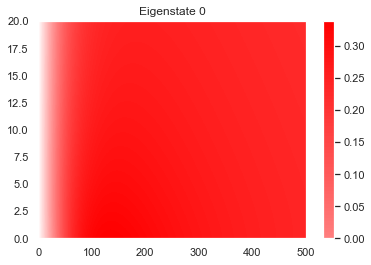

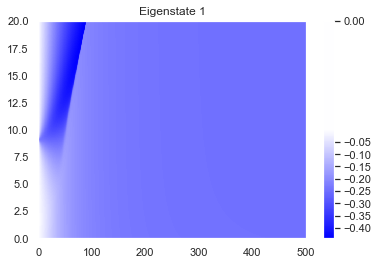

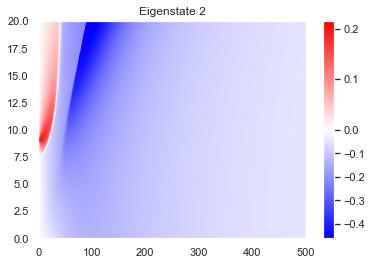

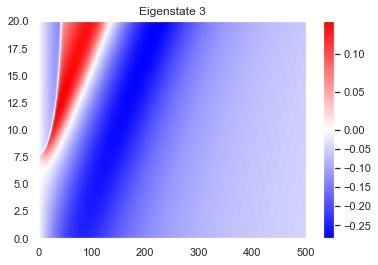

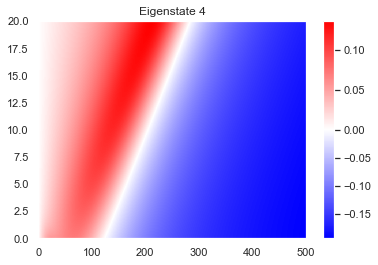

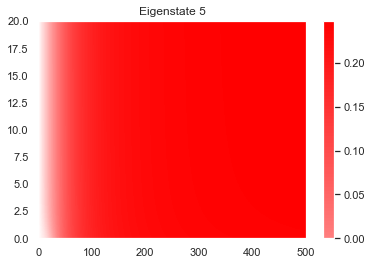

In [107]:
from matplotlib.colors import TwoSlopeNorm
for i in range(len(Bslices_p[0])):
    plt.figure()
    plt.pcolormesh(*mesh,Bslices_p[1][i],shading='auto',cmap='bwr',norm=TwoSlopeNorm(0))
    plt.colorbar()
    plt.title('Eigenstate {}'.format(i))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  


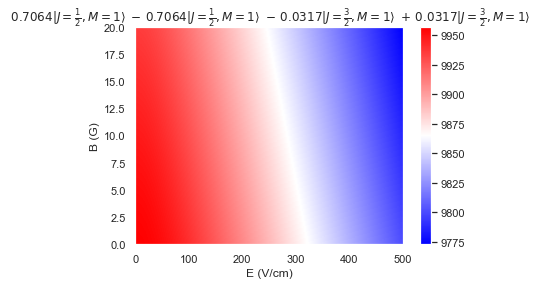

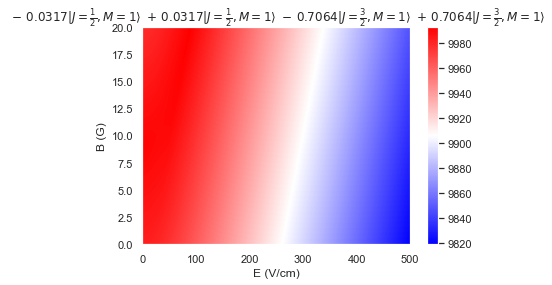

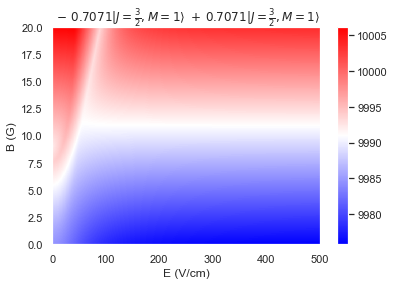

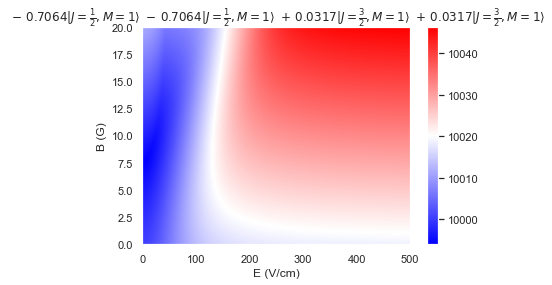

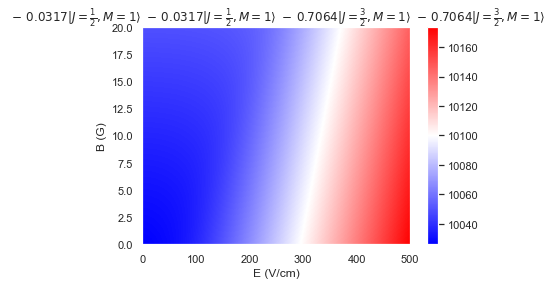

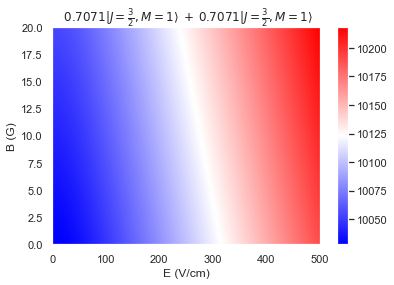

In [108]:
mesh = np.array(np.meshgrid(Ez,Bz,indexing='ij'))
for i in range(len(Bslices_p[0])):
    plt.figure()
    plt.grid(False)
    plt.pcolormesh(*mesh,Bslices_p[0][i],shading='auto',cmap='bwr')
    plt.colorbar()
    plt.title(X010_p.gen_state_str(i,round=4,label_q=['J','M']))
    plt.xlabel('E (V/cm)')
    plt.ylabel('B (G)')

In [73]:
np.gradient(Bslices_p[0][0])[1]/(Bz[1]-Bz[0])

array([[-5355728.85423, -2678181.5899 , -1339206.26323, ...,
           -7655.38735,    -7654.93535,    -7654.7095 ],
       [-5355531.53913, -2678082.64793, -1339156.52261, ...,
           -7655.38253,    -7654.93054,    -7654.70469],
       [-5354934.98431, -2677784.10418, -1339007.56767, ...,
           -7655.36806,    -7654.91609,    -7654.69025],
       ...,
       [  -30677.45953,   -17459.08086,   -10543.94911, ...,
           -7165.79655,    -7165.78812,    -7165.7839 ],
       [  -30660.62245,   -17451.45616,   -10540.68135, ...,
           -7165.76865,    -7165.76022,    -7165.75601],
       [  -30643.80722,   -17443.84186,   -10537.41838, ...,
           -7165.74078,    -7165.73236,    -7165.72816]])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  import sys


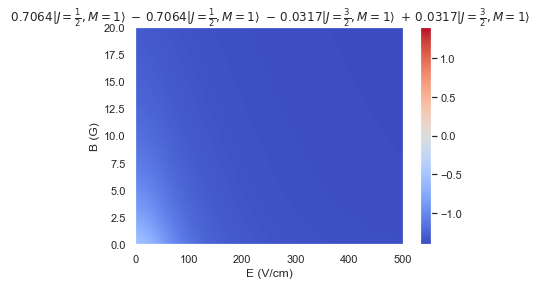

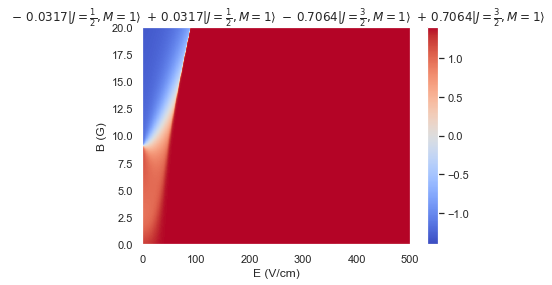

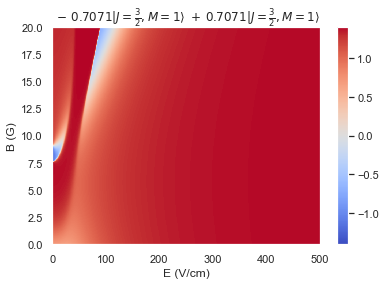

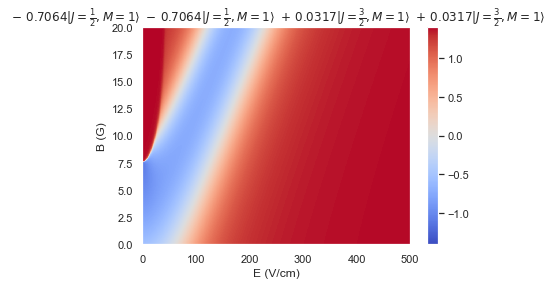

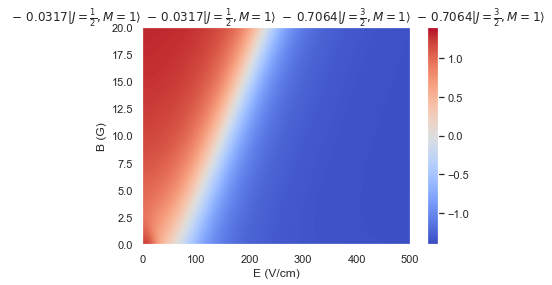

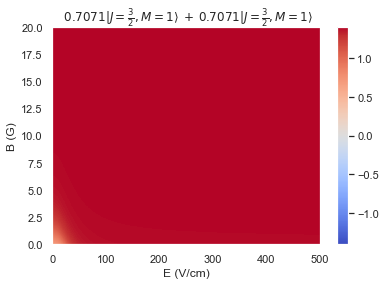

In [109]:
mesh = np.array(np.meshgrid(Ez,Bz,indexing='ij'))
for i in range(len(Bslices_p[0])):
    geff = np.gradient(Bslices_p[0][i])[1]/(Bz[1]-Bz[0])
    plt.figure()
    plt.grid(False)
    plt.pcolormesh(*mesh,geff,shading='auto',cmap='coolwarm',vmin=-1.4,vmax=1.4)
    plt.colorbar()
    plt.title(X010_p.gen_state_str(i,round=4,label_q=['J','M']))
    plt.xlabel('E (V/cm)')
    plt.ylabel('B (G)')

In [97]:
np.log10(-0.01)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


nan

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  import sys


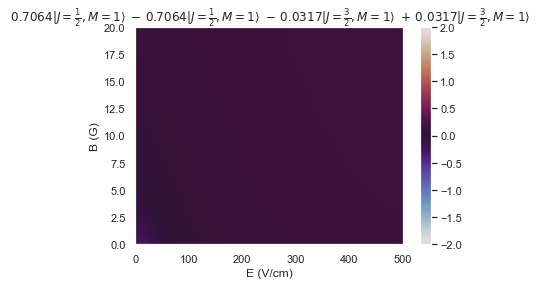

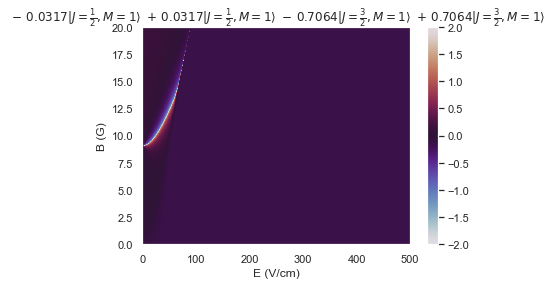

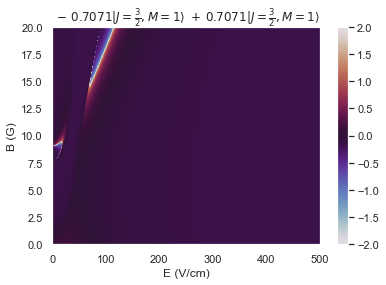

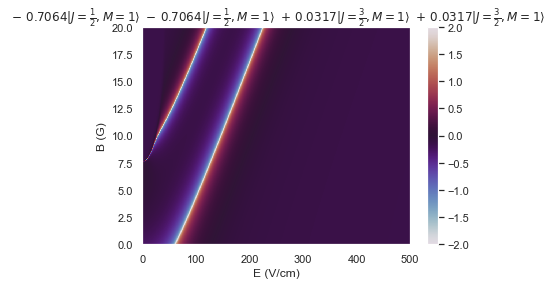

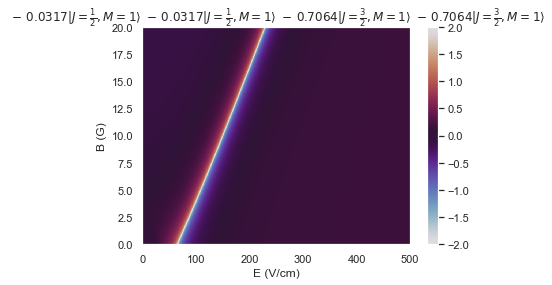

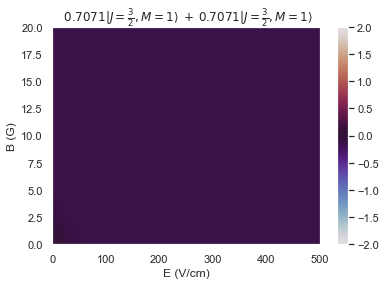

In [110]:
mesh = np.array(np.meshgrid(Ez,Bz,indexing='ij'))
for i in range(len(Bslices_p[0])):
    geff = np.gradient(Bslices_p[0][i])[1]/(Bz[1]-Bz[0])
    plt.figure()
    plt.grid(False)
    plt.pcolormesh(*mesh,-np.sign(geff)*np.log10(abs(geff)),shading='auto',cmap='twilight',vmin=-2,vmax=2)
    plt.colorbar()
    plt.title(X010_p.gen_state_str(i,round=4,label_q=['J','M']))
    plt.xlabel('E (V/cm)')
    plt.ylabel('B (G)')